In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras

In [2]:
import pandas as pd

In [3]:
df_gases_train = pd.read_pickle("./data_gases_train.pkl")
df_stitch_1_train = pd.read_pickle("./data_stitch_1_train.pkl")

In [4]:
df_gases_train = df_gases_train[['Um','Ur','Ud','C_target']]
df_stitch_1_train = df_stitch_1_train[['Um','Ur','Ud','C_target']]

In [14]:
df_gases_train.shape

(2437, 4)

In [15]:
df_stitch_1_train.shape

(1252, 4)

In [16]:
df_gases_train[df_gases_train['C_target'] == 0].shape

(937, 4)

In [5]:
additional_nonezero_objs = df_gases_train[df_gases_train['C_target'] != 0].sample(frac = 0.6, replace = False)
df_stitch_1_train_shrinked = df_stitch_1_train.sample(frac = 0.5)
df = pd.concat([df_gases_train, df_stitch_1_train_shrinked, additional_nonezero_objs])

In [6]:
features = df[['Um','Ur','Ud']]
target = df['C_target']

In [7]:
def set_nonelinear_features(features):
    features['Um^2'] = features['Um'].pow(2)
    features['Um^3'] = features['Um'].pow(3)
    features[f'ln(Um)'] = np.log(features['Um'])
    features['Ur^2'] = features['Ur'].pow(2)
    features['Ur^3'] = features['Ur'].pow(3)
    features['Ud^2'] = features['Ud'].pow(2)
    features['Ud^3'] = features['Ud'].pow(3)
    features['Um/Ur'] = features['Um']/features['Ur']
    features['Um/Ud'] = features['Um']/features['Ud']
    return features

In [8]:
features = set_nonelinear_features(features)
features.head(1)

,Um,Ur,Ud,Um^2,Um^3,ln(Um),Ur^2,Ur^3,Ud^2,Ud^3,Um/Ur,Um/Ud
0,0.70109,0.70087,0.77666,0.491527,0.344605,-0.355119,0.491219,0.34428,0.603201,0.468482,1.000314,0.902699


In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
features_train, features_val, target_train, target_val = train_test_split(features, target,
                                                                          test_size=0.1, random_state=42, shuffle=True)
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train) 
features_val = scaler.transform(features_val)

In [10]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras import regularizers
from keras.layers import Dropout

Using TensorFlow backend.


In [11]:
from keras.layers import BatchNormalization

In [12]:
target_val.reset_index(drop=True, inplace=True)

In [13]:
input_size = features_train.shape[1]
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
valid_set = [(features_val[i], target_val[i]) for i in range(0, target_val.size)]

one_layer_models = {}
two_layers_models = {}
optimizer = keras.optimizers.RMSprop(0.05)

for neurs_numb in range(4,24,6):
    one_layer_models[f'one_layer_model_{neurs_numb}'] = Sequential([
        Dense(neurs_numb, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.l1(0.001)),
        Dense(1)
      ])
    one_layer_models[f'one_layer_model_{neurs_numb}'].compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

In [14]:
target_train = target_train.to_numpy()
target_val = target_val.to_numpy()

In [15]:
one_layer_models_history = [(key, one_layer_models[key].fit(features_train, target_train, epochs=2000, batch_size = 200, shuffle=True,
                    validation_data=(features_val, target_val), verbose=0, callbacks=[early_stop])) for key in one_layer_models.keys()]

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
for neurs_numb_fst_layer in range(8,20,6):
    for neurs_numb_scd_layer in range(neurs_numb_fst_layer + 4,int(neurs_numb_fst_layer*0.66),-6):
        two_layers_models[f'two_layers_model_{neurs_numb_fst_layer}_{neurs_numb_scd_layer}'] = Sequential([
            Dense(neurs_numb_fst_layer, activation='relu', input_shape=(input_size,), kernel_regularizer=regularizers.l1(0.001)),
            Dense(neurs_numb_scd_layer, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
            Dense(1)
          ])
        two_layers_models[f'two_layers_model_{neurs_numb_fst_layer}_{neurs_numb_scd_layer}'].compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])

In [17]:
two_layers_models_history = [(key, two_layers_models[key].fit(features_train, target_train, epochs=2000, batch_size = 200, shuffle=True,
                    validation_data=(features_val, target_val), verbose=0, callbacks=[early_stop])) for key in two_layers_models.keys()]

In [18]:
import matplotlib.pyplot as plt

In [19]:
color_map =['red','blue','purple', 'green', 'black', 'yellow','brown', 'grey', 'orange','plum' , 'khaki', 'indigo']

In [20]:
def plot_history(history, xlim):    
    plt.figure(figsize=(40,20))
    for i in range(0,len(history)):
        model_name = history[i][0]
        hist = history[i][1].history
        epoch = history[i][1].epoch
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [$MPG^2$]')
        plt.plot(epoch, hist['mse'], ms=1.5, color=color_map[i],
           label=f'{model_name}_train')
        plt.plot(epoch, hist['val_mse'], color=color_map[i],
           label = f'{model_name}_val', ms=1.5, linestyle = '--')
        plt.ylim([0,3000000])
        plt.xlim([0,xlim])
    plt.legend(fontsize=24, markerscale=10)
    plt.show()

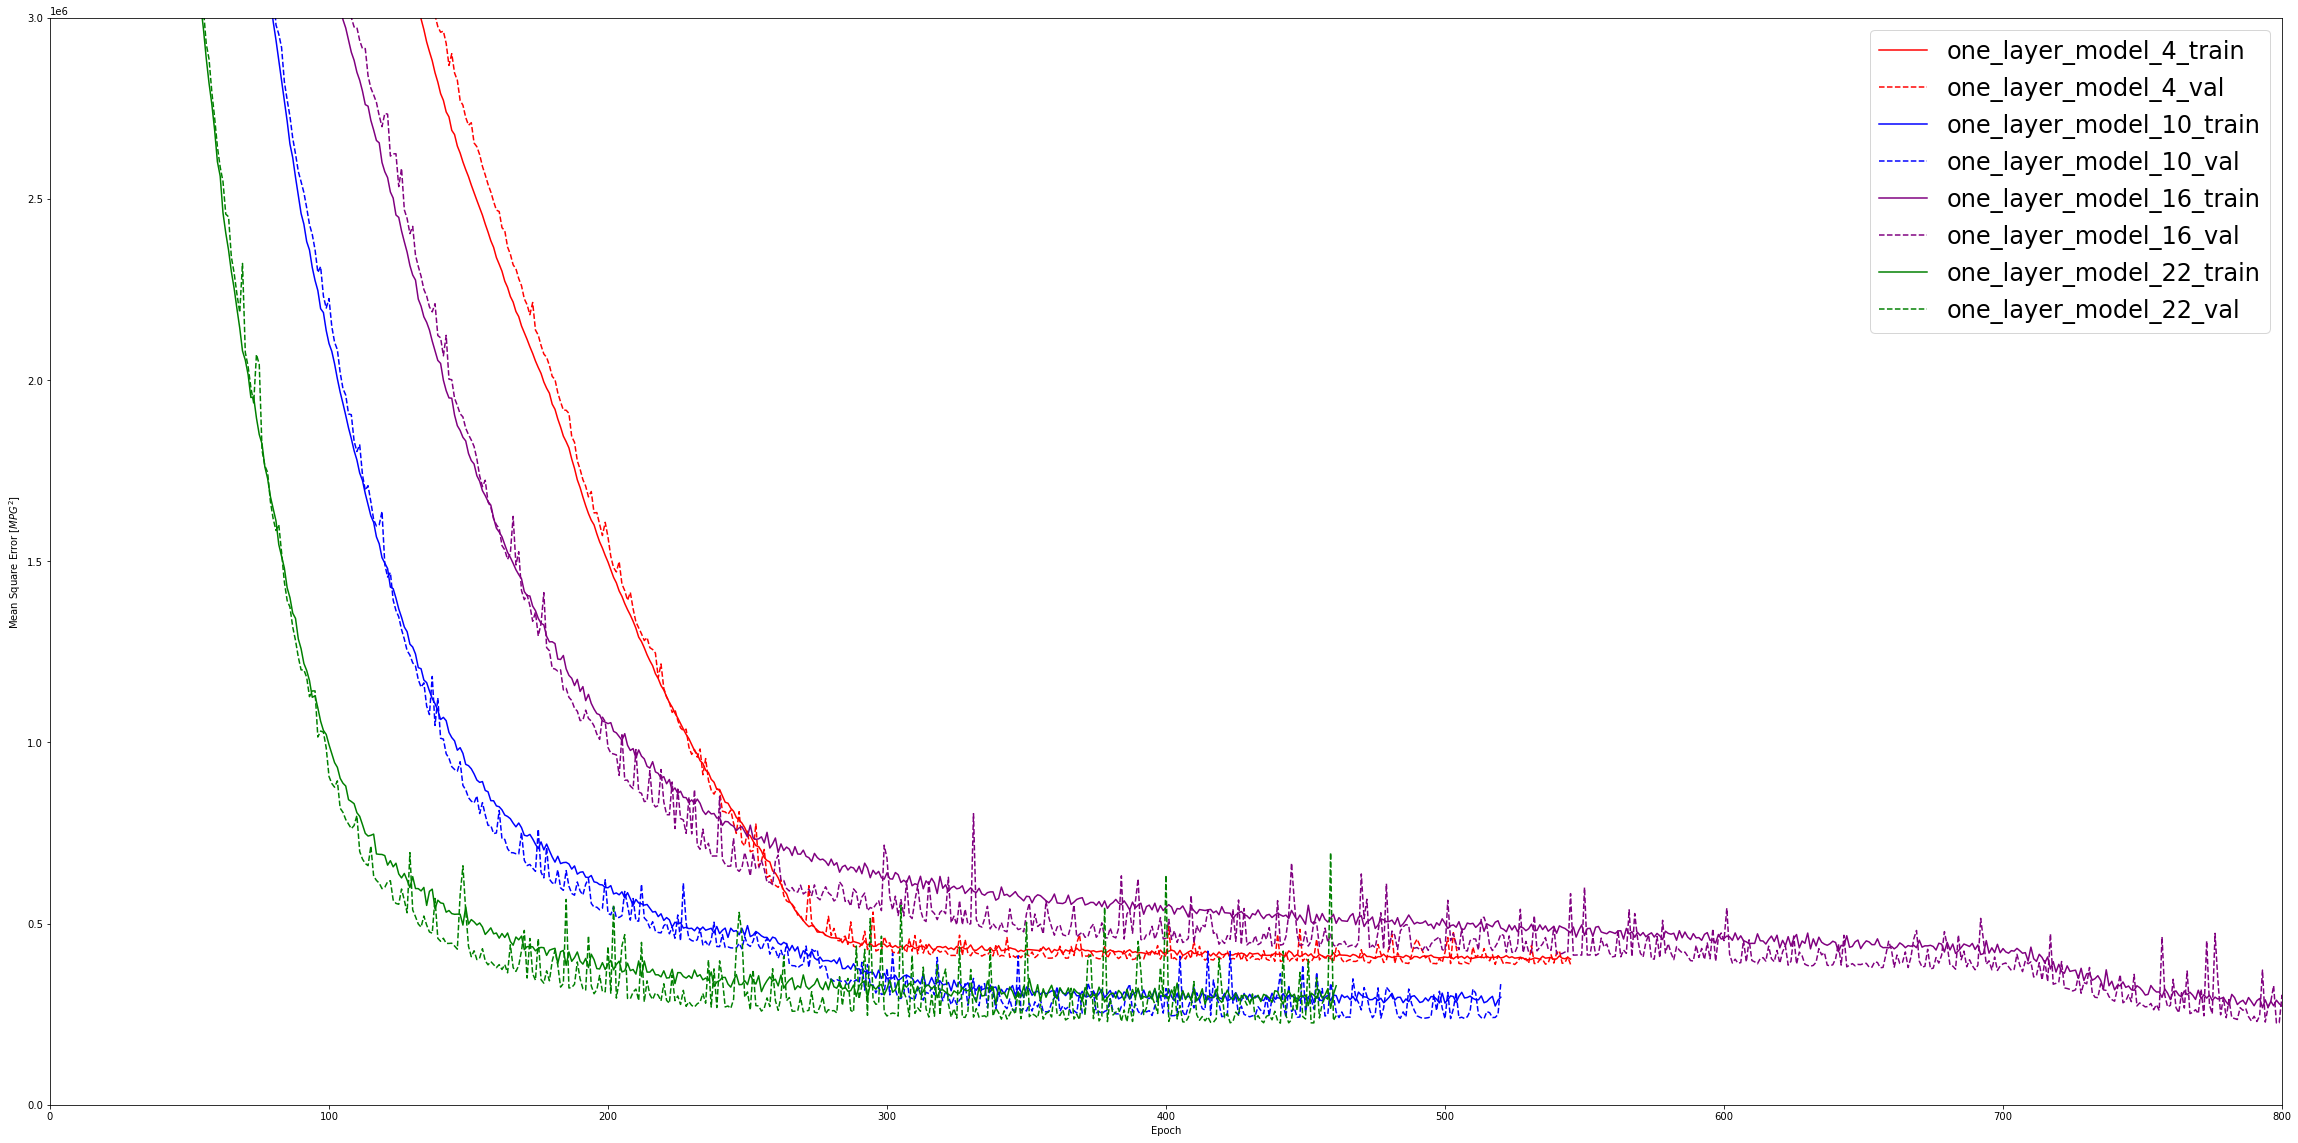

In [21]:
plot_history(one_layer_models_history, 800)

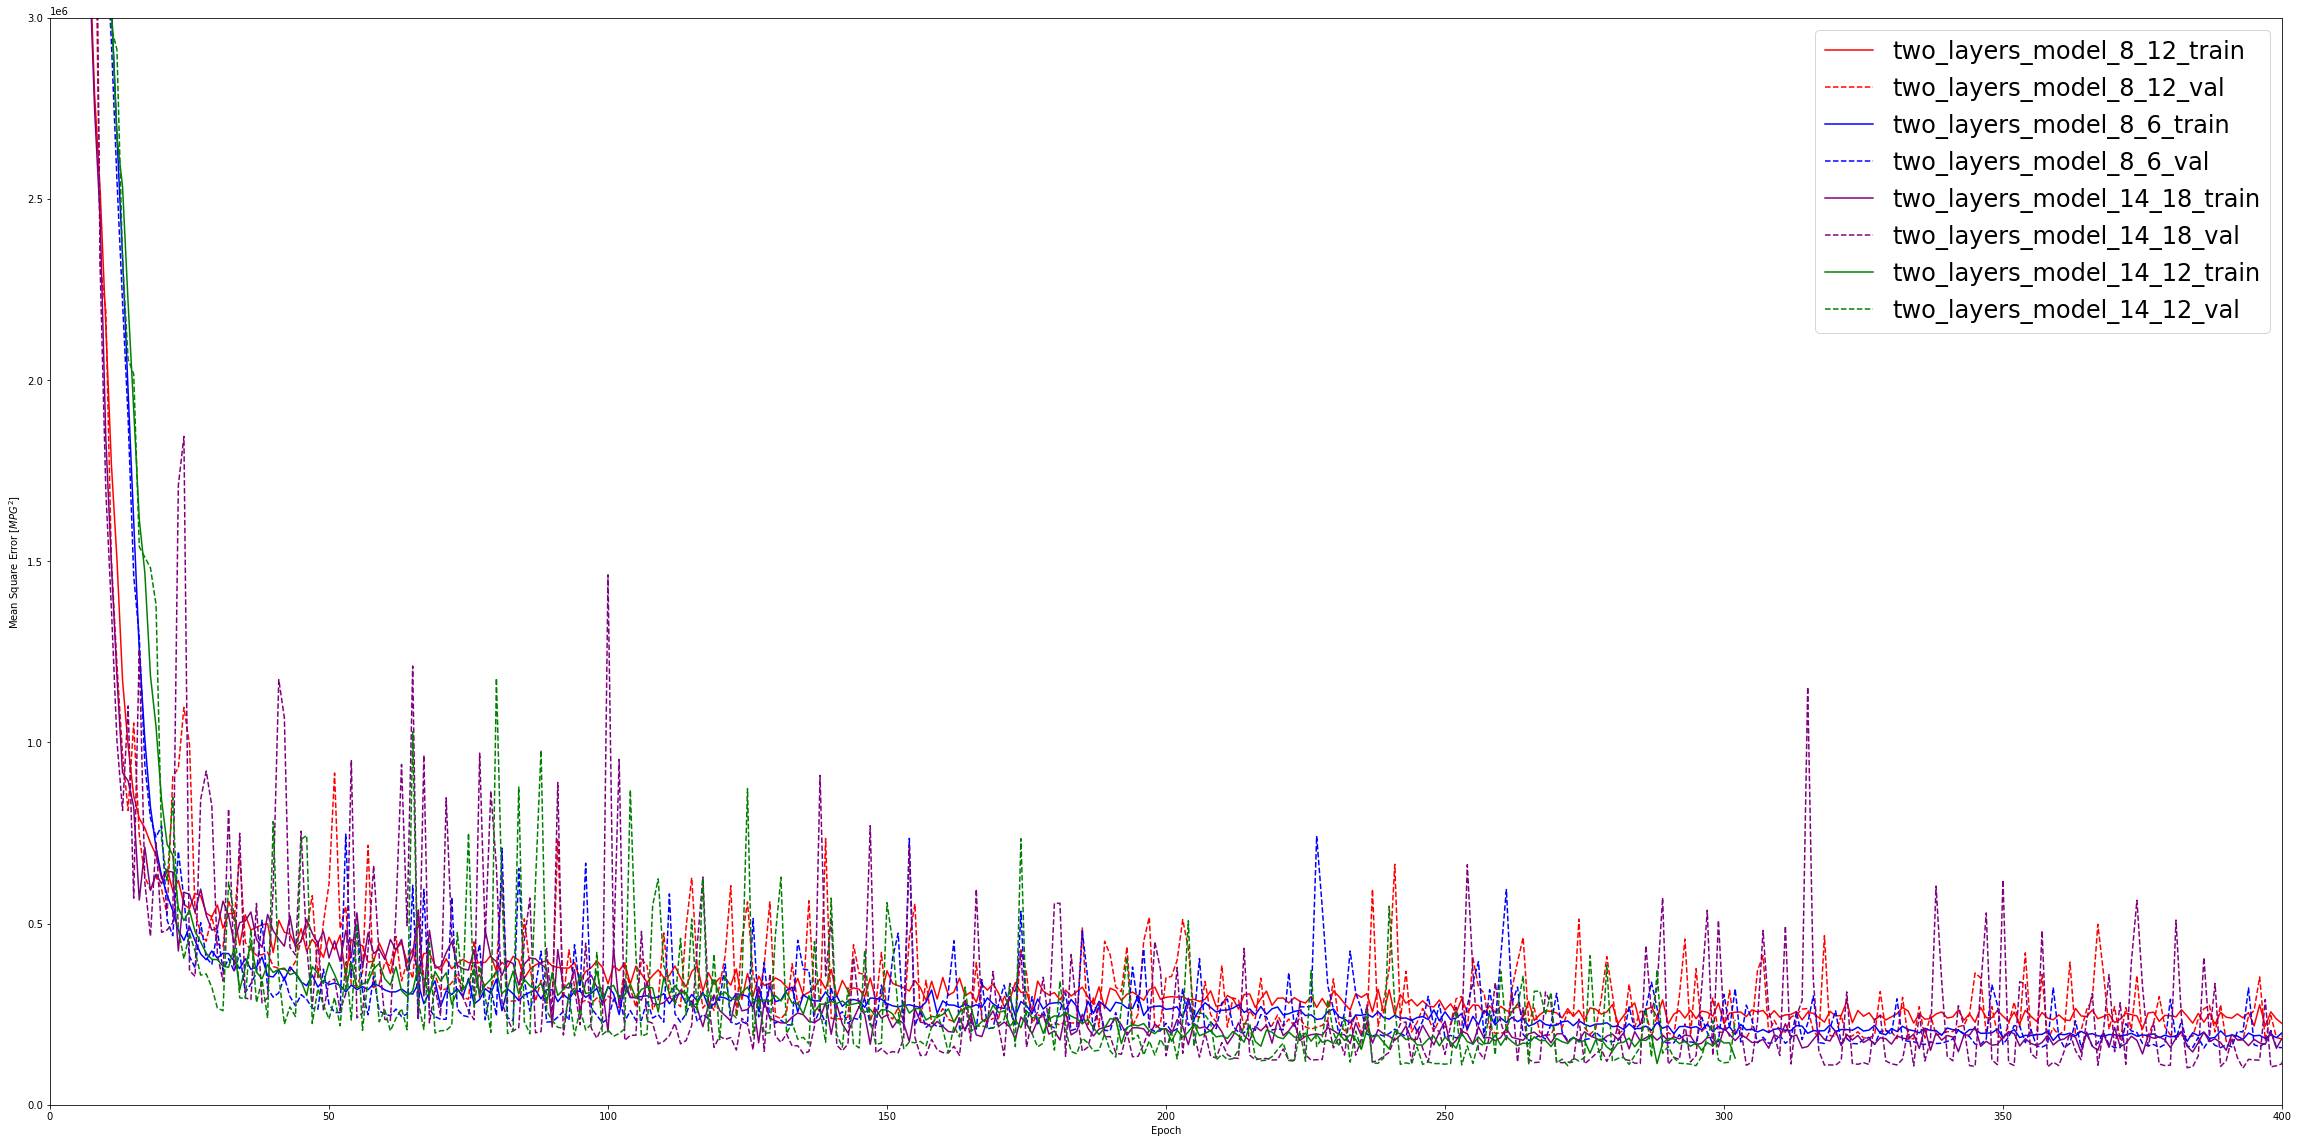

In [22]:
plot_history(two_layers_models_history, 400)

In [26]:
best_two_layers_model = two_layers_models_history[2]
best_two_layers_model[0]

'two_layers_model_14_18'

In [24]:
one_layer_model_10 = one_layer_models_history[1]
one_layer_model_10[0]

'one_layer_model_10'

In [29]:
one_layer_model_22 = one_layer_models_history[-1]
one_layer_model_22[0]

'one_layer_model_22'

In [27]:
best_two_layers_model_hist = pd.DataFrame(best_two_layers_model[1].history)
best_two_layers_model_hist['epoch'] = best_two_layers_model[1].epoch
best_two_layers_model_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
429,117099.034891,117096.359375,198420.565979,198417.890625,429
430,132147.758816,132145.093750,170086.247542,170083.578125,430
431,176421.211351,176418.531250,166275.635008,166272.968750,431
432,171803.353511,171800.687500,176624.280961,176621.625000,432
433,103017.877165,103015.195312,175220.375390,175217.656250,433
434,113151.595954,113148.906250,181334.973500,181332.281250,434
435,144023.152708,144020.468750,174190.805336,174188.093750,435
436,455337.633265,455334.937500,175029.058136,175026.375000,436
437,188977.342215,188974.625000,181885.306716,181882.593750,437
438,166725.362917,166722.656250,162747.338834,162744.625000,438


In [30]:
one_layer_model_22_hist = pd.DataFrame(one_layer_model_22[1].history)
one_layer_model_22_hist['epoch'] = one_layer_model_22[1].epoch
one_layer_model_22_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
452,226144.964539,226139.453125,308172.040066,308166.50000,452
453,226012.506730,226007.000000,302720.117551,302714.59375,453
454,350692.705211,350687.187500,294365.966454,294360.43750,454
455,239538.353078,239532.843750,316380.045149,316374.53125,455
456,279584.989688,279579.468750,294476.631485,294471.09375,456
457,297285.226700,297279.687500,302892.756371,302887.21875,457
458,291515.531958,291510.000000,320312.949173,320307.46875,458
459,695855.360989,695849.937500,266179.578099,266174.06250,459
460,232634.609257,232629.093750,304035.622546,304030.12500,460
461,246165.089027,246159.578125,328503.358648,328497.81250,461


In [31]:
one_layer_model_10_hist = pd.DataFrame(one_layer_model_10[1].history)
one_layer_model_10_hist['epoch'] = one_layer_model_10[1].epoch
one_layer_model_10_hist.tail(10)

,val_loss,val_mse,loss,mse,epoch
511,307599.624055,307595.937500,289971.739081,289968.03125,511
512,249183.977960,249180.296875,289629.939866,289626.28125,512
513,240605.503424,240601.796875,300482.534790,300478.84375,513
514,237769.489688,237765.781250,281655.980572,281652.31250,514
515,257258.114688,257254.421875,284826.852461,284823.15625,515
516,254103.705132,254100.015625,293143.095205,293139.40625,516
517,240841.916995,240838.203125,299343.858332,299340.12500,517
518,241114.493152,241110.796875,272604.667730,272601.03125,518
519,249301.283139,249297.578125,288723.761874,288720.09375,519
520,336144.661918,336140.968750,296960.062465,296956.37500,520


In [33]:
df_gases_2_test = pd.read_pickle("./data_gases_2_test.pkl")
C_target_test = df_gases_2_test['C_target']
C_original_unbiased = df_gases_2_test['C'] - 110.4721
features_test = df_gases_2_test[['Um','Ur','Ud']]
features_test = set_nonelinear_features(features_test)
features_test = scaler.transform(features_test)

D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [39]:
set(C_target_test)

{0.0, 497.99999999999994, 2540.0, 20500.0, 31000.0, 50000.0}

In [38]:
for target in sorted(set(C_target_test)):
    temp_test = df_gases_2_test[df_gases_2_test['C_target'] == target]
    C_original = temp_test['C']
    C_target = temp_test['C_target']
    temp_features = temp_test[['Um','Ur','Ud']]
    temp_features = set_nonelinear_features(temp_features)
    temp_features = scaler.transform(temp_features)
    temp_predict = one_layer_models[one_layer_model_22[0]].predict(temp_features,verbose=0)
    print(f"{target*1e-6:.4}%:  root mean squared error original C {np.sqrt(mean_squared_error(C_original, C_target))} and  evaluated {np.sqrt(mean_squared_error(temp_predict, C_target))} ")

0.0%:  root mean squared error original C 160.94261693667576 and  evaluated 203.81186814694658 
0.000498%:  root mean squared error original C 353.1492965235516 and  evaluated 193.72507450411072 
0.00254%:  root mean squared error original C 405.38832347958515 and  evaluated 352.5813029968031 
0.0205%:  root mean squared error original C 1019.6896464392751 and  evaluated 319.4530062124383 
0.031%:  root mean squared error original C 2039.6029357394177 and  evaluated 328.81358505411913 
0.05%:  root mean squared error original C 977.6768830835177 and  evaluated 490.54086845512273 


D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [188]:
best_two_layers_model_hist

,val_loss,val_mse,loss,mse,epoch
0,2.262290e+08,2.262290e+08,2.098285e+08,2.098285e+08,0
1,1.500930e+08,1.500930e+08,1.656187e+08,1.656187e+08,1
2,6.075489e+07,6.075488e+07,9.154454e+07,9.154453e+07,2
3,1.493221e+07,1.493221e+07,3.029060e+07,3.029060e+07,3
4,6.923763e+06,6.923762e+06,9.317748e+06,9.317746e+06,4
...,...,...,...,...,...
348,1.864260e+05,1.864234e+05,1.602374e+05,1.602348e+05,348
349,1.126762e+05,1.126737e+05,1.688662e+05,1.688636e+05,349
350,1.238871e+05,1.238845e+05,1.803899e+05,1.803874e+05,350
351,8.197993e+04,8.197736e+04,1.730412e+05,1.730387e+05,351


In [36]:
two_layers_predict = two_layers_models[best_two_layers_model[0]].predict(features_test,verbose=0)
one_layer_predict = one_layer_models[one_layer_model_22[0]].predict(features_test,verbose=0)

In [37]:
from sklearn.metrics import mean_squared_error
print(f'RMSE of unbiased original C  = {np.sqrt(mean_squared_error(C_original_unbiased, C_target_test))}')
print(f'RMSE of one layer NN prediction = {np.sqrt(mean_squared_error(one_layer_predict, C_target_test))}')
print(f'RMSE of two layers NN prediction = {np.sqrt(mean_squared_error(two_layers_predict, C_target_test))}')

RMSE of unbiased original C  = 891.7619823348223
RMSE of one layer NN prediction = 289.9649964643292
RMSE of two layers NN prediction = 421.5132606597785


In [191]:
df_stitch_2 = pd.read_pickle("./data_stitch_2.pkl")

In [192]:
df_stitch_2_sample = df_stitch_2.sample(1000)

In [193]:
C_target_stitch = df_stitch_2_sample['C_target']
features_stitch = df_stitch_2_sample[['Um','Ur','Ud']]
features_stitch = set_nonelinear_features(features_stitch)
features_stitch = scaler.transform(features_stitch)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [195]:
two_layers_predict_stitch = two_layers_models[best_two_layers_model[0]].predict(features_stitch,verbose=0)
one_layer_predict_stitch = one_layer_models[one_layer_model_22[0]].predict(features_stitch,verbose=0)
print(f'RMSE of one layer NN prediction on stitch = {np.sqrt(mean_squared_error(one_layer_predict_stitch, C_target_stitch))}')
print(f'RMSE of two layers NN prediction on stitch = {np.sqrt(mean_squared_error(two_layers_predict_stitch, C_target_stitch))}')

RMSE of one layer NN prediction on stitch = 1157.8468001677866
RMSE of two layers NN prediction on stitch = 1004.5404429302235


In [198]:
overview_stitch = pd.DataFrame({'C_pred': two_layers_predict_stitch.flatten(), 'C_target': C_target_stitch, 'Ur': df_stitch_2_sample['Ur']},
                             columns=[ 'C_pred', 'C_target', 'Ur'])

In [200]:
overview_stitch.reset_index(inplace=True)

In [202]:
overview_stitch.head(20)

,index,C_pred,C_target,Ur
0,2380,644.472351,0.0,0.45891
1,6895,-266.596252,0.0,0.64927
2,13988,63.515808,0.0,0.70066
3,1105,447.973816,0.0,0.53013
4,5488,-78.926086,0.0,0.61624
5,11993,303.882141,0.0,0.69514
6,5990,-132.761658,0.0,0.63007
7,3871,171.410095,0.0,0.55546
8,8515,1125.437866,0.0,0.67354
9,5124,-18.688295,0.0,0.60522


In [203]:
import os.path
if os.path.isfile('two_layers_model.h5') is False:
    two_layers_models[best_two_layers_model[0]].save_weights('two_layers_model.h5')

In [204]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

In [206]:
from sklearn.externals.joblib import dump, load
if os.path.isfile('std_scaler_for_nn.bin') is False:
    dump(scaler, 'std_scaler_for_nn.bin', compress=True)
#sc=load('std_scaler.bin')